In [1]:
from spikeforest2_utils import AutoRecordingExtractor, AutoSortingExtractor
import kachery as ka

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from neurodsp.filt import filter_signal
from bycycle.spikes.objs import SpikesMEA

from sklearn.cluster import KMeans

### Download spikeforest data

In [2]:
# Configure kachery to download data from the public database
ka.set_config(fr='default_readonly')

# Specify the recording and ground truth sorting
#recording_path = 'sha1dir://3ea5c9bd992de2d27402b2e83259c679d76e9319.synth_mearec_tetrode/datasets_noise10_K10_C4/001_synth'
#sorting_true_path = 'sha1dir://3ea5c9bd992de2d27402b2e83259c679d76e9319.synth_mearec_tetrode/datasets_noise10_K10_C4/001_synth/firings_true.mda'
recording_path = 'sha1dir://fb52d510d2543634e247e0d2d1d4390be9ed9e20.synth_magland/datasets_noise10_K10_C4/001_synth'
sorting_true_path = 'sha1dir://fb52d510d2543634e247e0d2d1d4390be9ed9e20.synth_magland/datasets_noise10_K10_C4/001_synth/firings_true.mda'

recording = AutoRecordingExtractor(recording_path, download=True)
sorting_true = AutoSortingExtractor(sorting_true_path)

### Filtering

A bandpass filter from 300-3000hz is applied to each electrode's signal independently.

In [3]:
fs = 30000

sigs = recording.get_traces()

times = np.arange(0, len(sigs[0])/fs, 1/fs)

# Filter
sigs_filt = np.zeros((len(sigs), len(sigs[0])))

for idx, sig in enumerate(sigs):
    sigs_filt[idx] = filter_signal(sig, fs, 'bandpass', (300, 3000), remove_edges=False)

### True Units

The contibutions from each electrode on each unit are plotted below. 

In [4]:
def plot_true_units(sig, fs, ts, pad, color=None, ax=None, title=None, ylim=None):
    
    # Split signal
    _sig = np.zeros((len(ts), int(pad * 2)))

    for idx, t in enumerate(ts):
        sig_tmp = sig[t-pad:t+pad]        
        _sig[idx] = sig_tmp
    
    # Mean and std
    mean_sig = _sig.mean(axis=0)
    std_sig = _sig.std(axis=0)
    
    # Plot
    ax.fill_between(np.arange(int(pad * 2)), mean_sig - std_sig,
                    mean_sig + std_sig, color=color, alpha=.2)
    
    ax.plot(mean_sig, lw=2, color=color, alpha=.5)

    ax.set_ylim((ylim))
    ax.set_title(title)

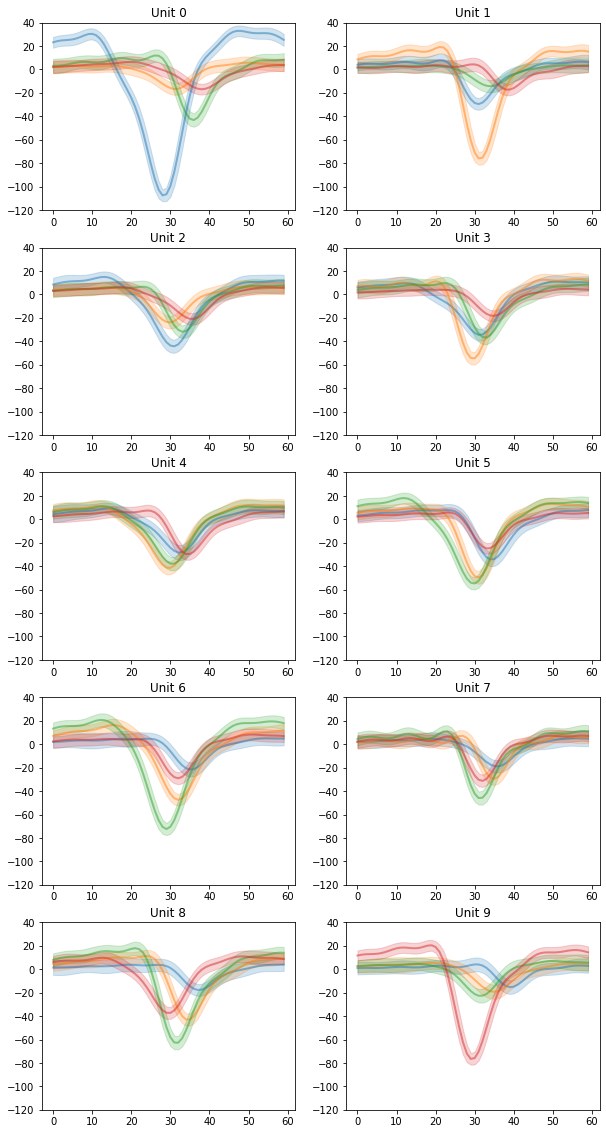

In [5]:
fig, axes = plt.subplots(figsize=(10, 20), nrows=5, ncols=2)


ax_idxs = ((row, col) for row in range(5) for col in range(2))

for uidx in range(1, 11):
    
    ax = axes[next(ax_idxs)]
    
    for eidx in range(4):
        
        plot_true_units(sigs_filt[eidx], fs, sorting_true.get_unit_spike_train(uidx), 30,
                         ax=ax, ylim=(-120, 40), color='C' + str(eidx), title='Unit ' + str(uidx-1))

### Feature Extraction

Two sets of features will be used to separately cluster the spikes into putative units.

The first set of features are the voltages at the extrema and zero-crossings for each spike. Extrema and zero-crossing are found from a mean spike and the voltage contributions of each electrode's signal are found at these timepoints.

The second set of features are the first 4 PCA component scores. A mean signal is used to find spike minima (trough) locations. The pad parameter includes 20 samples to the left and right of the each minima.

In [6]:
mea = SpikesMEA()

# Extrema/Zero-crossings voltage features
mea.fit(sigs_filt, fs, std=3, n_gaussians=3, tol=1e-2, chunksize=1000, f_range=(1000, 3000), progress='tqdm.notebook')

# PCA features (requires sklearn)
mea.pca(pad=20, n_components=4)

Computing Bycycle Features:   0%|          | 0/14076 [00:00<?, ?it/s]

### Clustering: K-Means

Spikes are limited to those that are known and have true labels. K-means clustering is then used to sort the spikes. 

Because this data is simulated, we know the number of clusters to search for. In real data, this may not be the case and the optimal number of clusters may be found using silhouette scores in these cases.

In [29]:
# Sort true labels and corresponding sample indices
true_labels = []
spike_idxs = []

for idx in range(0, 10):
    
    # True unit locations (note: true labels start at 1)
    locs = sorting_true.get_unit_spike_train(idx + 1)
    
    # Get corresponding cluster labels
    n_spikes = 0
    for loc in locs:
        
        spike_idx = np.where((mea.df_features['sample_start'] <= loc) & \
                             (mea.df_features['sample_end']   >= loc))[0]
        
        if len(spike_idx) == 1:
            spike_idxs.append(spike_idx[0])
            n_spikes += 1
    
    true_labels.append([idx] * n_spikes)
    
true_labels = np.hstack(true_labels)
spike_idxs = np.array(spike_idxs)

# Get features
features_volts = mea.volts[spike_idxs]
features_pca = mea.components[spike_idxs]

params = ['center0', 'height0', 'std0', 'alpha0']

features_params = mea.df_features[params].values

### Results

The clustering accuracy is compared between the two features (voltages vs PCA components) sets.

In [15]:
# Performance
def cluster_performance(clusters, true_labels):
    
    df_clust = pd.DataFrame()
    df_clust['true_unit'] = list(range(10))
    
    accuracy = []
    n_clusters = len(np.unique(clusters))
    
    for clust_idx in range(n_clusters):

        labels_pred = true_labels[np.where(clusters == clust_idx)[0]]

        label_counts = []
        for idx in range(n_clusters):
            label_counts.append(len(np.where(labels_pred == idx)[0]))

        df_clust['cluster_' + str(clust_idx)] = label_counts[:10]
        
    for unit_idx in range(10):
        
        accuracy.append(max(df_clust.values[unit_idx, :]) / \
                        len(np.where(true_labels == unit_idx)[0]))

    
    df_clust['accuracy'] = accuracy
   
    return df_clust

In [25]:
from sklearn.preprocessing import StandardScaler

### K-Means: Fit Params

In [30]:
# 10 clusters

features_params = StandardScaler().fit_transform(features_params)

clusters_params = KMeans(n_clusters=10, random_state=0).fit_predict(features_params)

df_clust = cluster_performance(clusters_params, true_labels)

df_clust.drop(labels='accuracy', axis=1)

,true_unit,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0,123,166,206,6,172,58,142,39,240,246
1,1,140,155,191,14,139,54,154,42,249,264
2,2,126,167,219,14,130,54,147,44,245,261
3,3,121,186,201,15,134,52,150,38,257,283
4,4,118,175,201,10,156,66,148,34,236,276
5,5,128,160,196,5,155,60,134,33,242,281
6,6,106,178,238,10,145,48,136,40,225,273
7,7,109,204,221,16,169,67,113,35,240,258
8,8,115,146,174,18,132,68,146,47,255,298
9,9,118,158,192,16,161,56,135,31,232,289


### K-Means: Voltages

In [23]:
# 10 clusters
clusters_volts = KMeans(n_clusters=10, random_state=0).fit_predict(features_volts)

df_clust = cluster_performance(clusters_volts, true_labels)

df_clust

,true_unit,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,accuracy
0,0,0,13,0,1,5,1378,0,1,0,0,0.985694
1,1,0,0,0,1390,0,0,1,3,3,5,0.991441
2,2,0,1391,1,0,2,3,0,2,3,5,0.988628
3,3,2,7,0,2,4,0,0,1399,16,7,0.973556
4,4,2,3,0,3,1,2,1,9,1394,5,0.981690
5,5,7,0,0,0,0,2,1,0,6,1378,0.988522
6,6,1359,0,0,1,14,2,2,0,1,20,0.971408
7,7,3,4,1,1,4,0,1375,0,40,4,0.960196
8,8,26,0,1,0,1354,1,16,0,0,1,0.967834
9,9,2,1,1402,1,5,1,5,0,0,4,0.986629


### K-Means: PCA Components

In [13]:
# 10 clusters
clusters_pca = KMeans(n_clusters=10, random_state=0).fit_predict(features_pca)

df_pca = cluster_performance(clusters_pca, true_labels)

df_pca

,true_unit,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,accuracy
0,0,0,1,1391,1,0,3,1,1,0,0,0.994993
1,1,0,1,1,5,0,0,3,2,1386,4,0.988588
2,2,1388,2,3,6,1,1,1,3,0,2,0.986496
3,3,3,3,0,1408,0,3,0,10,3,7,0.979819
4,4,4,0,2,8,0,3,1,1392,2,8,0.980282
5,5,0,0,2,0,0,5,1,3,0,1383,0.992109
6,6,0,0,1,0,0,1387,0,1,0,10,0.991422
7,7,0,5,0,1,1,2,1416,2,1,4,0.988827
8,8,0,1384,1,0,0,8,6,0,0,0,0.989278
9,9,0,7,2,1,1401,4,3,0,1,2,0.985925
